In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

In [4]:
#Get the data and process the data
train_data = tfds.load('fashion_mnist' , split='train')
test_data  = tfds.load('fashion_mnist' , split="test")

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete3TDMBU/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete3TDMBU/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
def process_data(data):
    image = data['image']
    image = tf.reshape(image , [-1])
    image = tf.cast(image , tf.float32)
    image = image / 255.0

    return image , data['label']

In [6]:
train_data = train_data.map(process_data)
test_data  = test_data.map(process_data)

In [7]:
batch_size = 64

train_data = train_data.shuffle(buffer_size=1024).batch(batch_size)
test_data  = test_data.batch(batch_size)

In [8]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [9]:
def base_model():
    input  = Input(shape=(28*28 , ) , name = "input_layer")
    x = Dense(64 , activation=relu , name = "dense1")(input)
    x = Dense(64 , activation=relu , name = "dense2")(x)
    output = Dense(10 , activation=softmax , name="output_layer")(x)
    model = Model(inputs = input , outputs = output)
    return model

In [11]:
loss_obj       = SparseCategoricalCrossentropy()
optimizer_obj  = Adam()

train_acc_matrix = SparseCategoricalAccuracy()
val_acc_matrix   = SparseCategoricalAccuracy()

In [14]:
def run_optimizer(model , x , y_true):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_val = loss_obj(y_true=y_true , y_pred=logits)
    grad = tape.gradient(loss_val , model.trainable_weights)
    optimizer_obj.apply_gradients(zip(grad , model.trainable_weights))

    return logits , loss_val

In [34]:
def train_one_epoch(model , train_data):
    losses = []
    pbar = tqdm(total=len(list(enumerate(train_data))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for batch_no , (data , label) in enumerate(train_data):
        y_pred , loss = run_optimizer(model , data , label)
        losses.append(loss)
        train_acc_matrix(label , y_pred)
        pbar.set_description("Training loss for step %s: %.4f" % (int(batch_no), float(loss)))
        pbar.update()
    return losses

In [28]:
def perform_validation(model , test_data):
    losses = []
    for (data , label) in test_data:
        y_pred = model(data)
        loss = loss_obj(label , y_pred)
        losses.append(loss)
        val_acc_matrix(label , y_pred)
    return losses

In [43]:
def train(train , test , epochs = 10):
    model = base_model()

    history = {}
    history['train_loss'] = []
    history['val_loss'] = []

    history['train_acc'] = []
    history['val_acc'] = []

    val_epoch_loss   = []
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        train_losses = train_one_epoch(model , train_data=train)
        train_acc    = train_acc_matrix.result()
        history['train_acc'].append(train_acc.numpy())
        train_acc_matrix.reset_states()

        val_losses   = perform_validation(model , test_data=test)
        val_acc      = val_acc_matrix.result()
        history['val_acc'].append(val_acc.numpy())
        val_acc_matrix.reset_states()

        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))

        print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f,\
         Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(np.mean(train_losses)), float(np.mean(val_losses)),
                                                            float(train_acc), float(val_acc)))

    history['model'] = model
    return history

In [44]:
history = train(train_data , test_data)

Start of epoch 0


Training loss for step 937: 0.3110: 100%|█████████▉| 937/938 


 Epoch 0: Train loss: 0.4813  Validation Loss: 0.4174,         Train Accuracy: 0.8266, Validation Accuracy 0.8488
Start of epoch 1


Training loss for step 937: 0.2452: 100%|█████████▉| 937/938 


 Epoch 1: Train loss: 0.3641  Validation Loss: 0.3860,         Train Accuracy: 0.8673, Validation Accuracy 0.8619
Start of epoch 2


Training loss for step 937: 0.2452: 100%|██████████| 938/938 


 Epoch 2: Train loss: 0.3357  Validation Loss: 0.3646,         Train Accuracy: 0.8778, Validation Accuracy 0.8721
Start of epoch 3


Training loss for step 937: 0.3233: 100%|██████████| 938/938 


 Epoch 3: Train loss: 0.3149  Validation Loss: 0.3631,         Train Accuracy: 0.8854, Validation Accuracy 0.8692
Start of epoch 4


Training loss for step 937: 0.3374: 100%|█████████▉| 937/938 


 Epoch 4: Train loss: 0.3006  Validation Loss: 0.3607,         Train Accuracy: 0.8895, Validation Accuracy 0.8754
Start of epoch 5


Training loss for step 937: 0.2294: 100%|█████████▉| 937/938 


 Epoch 5: Train loss: 0.2869  Validation Loss: 0.3589,         Train Accuracy: 0.8944, Validation Accuracy 0.8740
Start of epoch 6


Training loss for step 937: 0.2280: 100%|█████████▉| 937/938 


 Epoch 6: Train loss: 0.2765  Validation Loss: 0.3507,         Train Accuracy: 0.8977, Validation Accuracy 0.8778
Start of epoch 7


Training loss for step 937: 0.2280: 100%|██████████| 938/938 


 Epoch 7: Train loss: 0.2674  Validation Loss: 0.3640,         Train Accuracy: 0.9008, Validation Accuracy 0.8740
Start of epoch 8


Training loss for step 937: 0.2734: 100%|█████████▉| 937/938 


 Epoch 8: Train loss: 0.2605  Validation Loss: 0.3422,         Train Accuracy: 0.9035, Validation Accuracy 0.8813
Start of epoch 9


Training loss for step 937: 0.2467: 100%|█████████▉| 937/938 


 Epoch 9: Train loss: 0.2539  Validation Loss: 0.3637,         Train Accuracy: 0.9057, Validation Accuracy 0.8705


Text(0.5, 1.0, 'Loss')

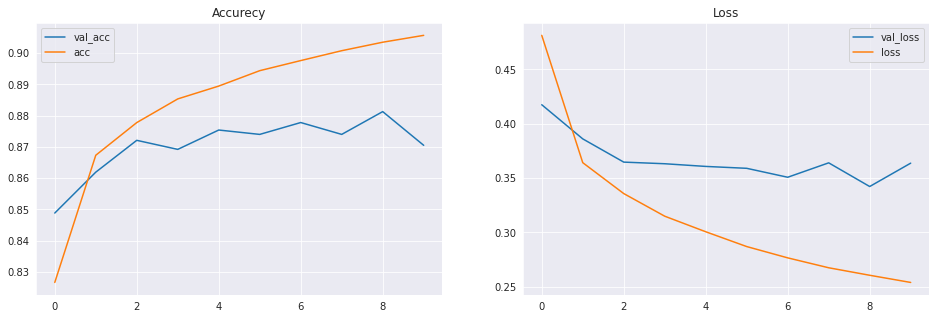

In [51]:
import seaborn as sns
sns.set_style("darkgrid")

fig , ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(history['val_acc'] , label="val_acc")
ax[0].plot(history['train_acc'] , label="acc")
ax[0].legend()
ax[0].set_title("Accurecy")

ax[1].plot(history['val_loss'] , label="val_loss")
ax[1].plot(history['train_loss'] , label="loss")
ax[1].legend()
ax[1].set_title("Loss")